In [4]:
!pip install pmdarima


     |████████████████████████████████| 595 kB 2.4 MB/s eta 0:00:01


In [24]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [25]:
import yfinance as yf

stock_data = yf.download('TSLA','2015-01-01','2020-12-31')
stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,44.618000,45.136002,44.450001,44.481998,44.481998,11487500
2015-01-02,44.574001,44.650002,42.652000,43.862000,43.862000,23822000
2015-01-05,42.910000,43.299999,41.431999,42.018002,42.018002,26842500
2015-01-06,42.012001,42.840000,40.841999,42.256001,42.256001,31309500
2015-01-07,42.669998,42.956001,41.956001,42.189999,42.189999,14842000
...,...,...,...,...,...,...
2020-12-23,632.200012,651.500000,622.570007,645.979980,645.979980,33173000
2020-12-24,642.989990,666.090027,641.000000,661.770020,661.770020,22865600
2020-12-28,674.510010,681.400024,660.799988,663.690002,663.690002,32278600


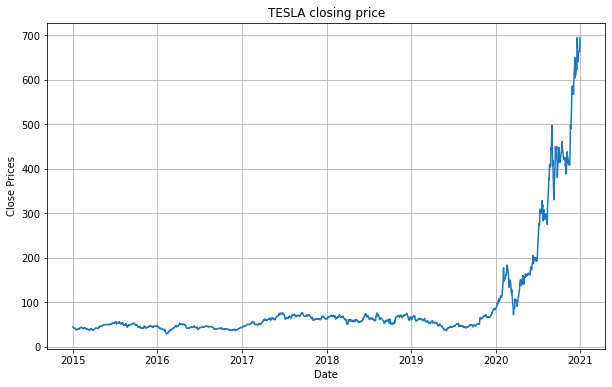

In [26]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('TESLA closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

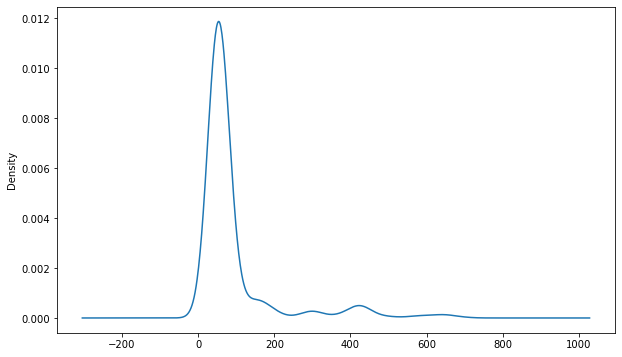

In [27]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

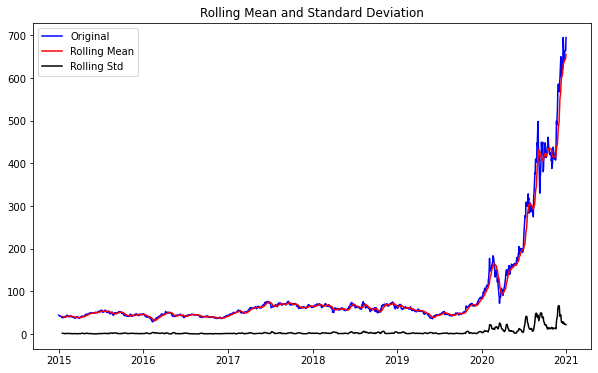

Results of dickey fuller test
Test Statistics                   6.317307
p-value                           1.000000
No. of lags used                 23.000000
Number of observations used    1487.000000
critical value (1%)              -3.434755
critical value (5%)              -2.863486
critical value (10%)             -2.567806
dtype: float64


In [28]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

No handles with labels found to put in legend.


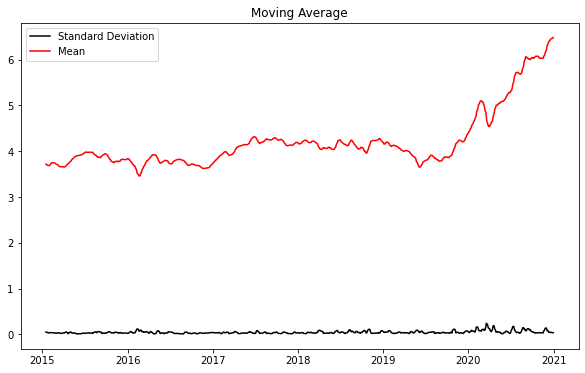

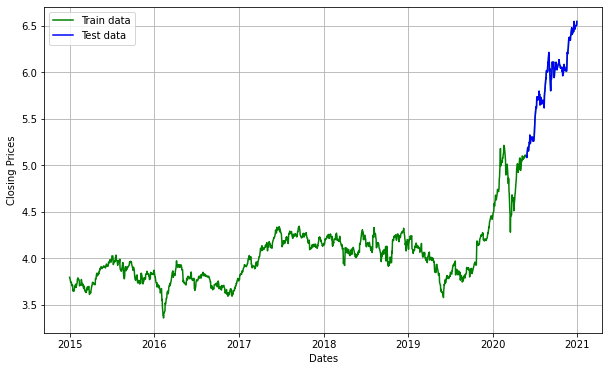

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()
#ARIMA
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [30]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
#model_autoARIMA.plot_diagnostics(figsize=(15,8))
#plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5422.891, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5421.429, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5421.386, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5423.622, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5420.112, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.753 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1356
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2712.811
Date:                Thu, 09 Dec 2021   AIC                          -5423.622
Time:                        09:30:44   BIC                          -5418.410
Sample:                             0   HQIC                         -5421.670
                               - 1356                                  

In [31]:
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1355
Model:                 ARIMA(1, 1, 2)   Log Likelihood                2715.160
Method:                       css-mle   S.D. of innovations              0.033
Date:                Thu, 09 Dec 2021   AIC                          -5420.319
Time:                        09:30:50   BIC                          -5394.261
Sample:                             1   HQIC                         -5410.562
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.001      1.048      0.295      -0.001       0.003
ar.L1.D.Close     0.1635      0.318      0.514      0.607      -0.460       0.787
ma.L1.D.Close    -0.1453      0.317     

In [32]:
fc, se, conf = fitted.forecast(152, alpha=0.05) 

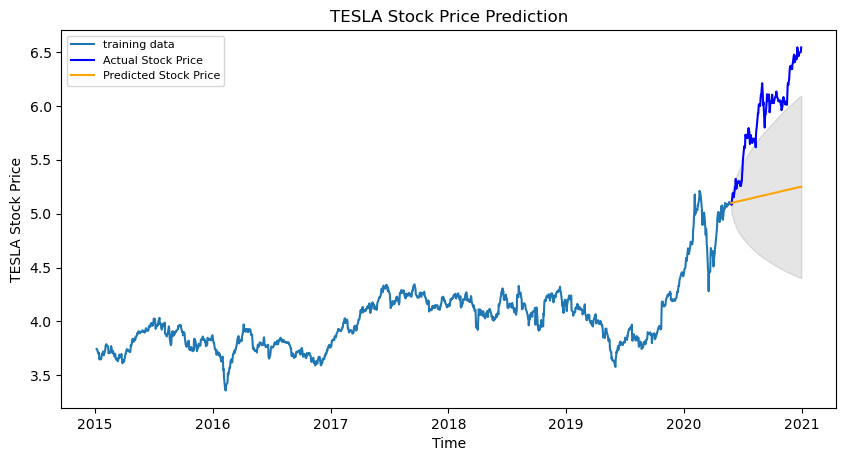

In [33]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()